## 导入模块

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [9]:
!dir

 Volume in drive D is New Volume
 Volume Serial Number is 4AD5-03DA

 Directory of D:\Downloads\wechat

06/17/2020  03:28 PM    <DIR>          .
06/17/2020  03:28 PM    <DIR>          ..
06/17/2020  03:14 PM    <DIR>          .ipynb_checkpoints
06/17/2020  03:04 PM    <DIR>          name_classification
06/17/2020  03:28 PM             2,245 name_classification.ipynb
06/17/2020  12:58 AM            11,543 RNN.ipynb
               2 File(s)         13,788 bytes
               4 Dir(s)  396,096,294,912 bytes free


## 定义函数 

In [10]:
def findFiles(path): return glob.glob(path)
print(findFiles('name_classification/data/names/*.txt'))

['name_classification/data/names\\Arabic.txt', 'name_classification/data/names\\Chinese.txt', 'name_classification/data/names\\Czech.txt', 'name_classification/data/names\\Dutch.txt', 'name_classification/data/names\\English.txt', 'name_classification/data/names\\French.txt', 'name_classification/data/names\\German.txt', 'name_classification/data/names\\Greek.txt', 'name_classification/data/names\\Irish.txt', 'name_classification/data/names\\Italian.txt', 'name_classification/data/names\\Japanese.txt', 'name_classification/data/names\\Korean.txt', 'name_classification/data/names\\Polish.txt', 'name_classification/data/names\\Portuguese.txt', 'name_classification/data/names\\Russian.txt', 'name_classification/data/names\\Scottish.txt', 'name_classification/data/names\\Spanish.txt', 'name_classification/data/names\\Vietnamese.txt']


## 将Unicode字符转化成纯ASCII码 

In [11]:
import unicodedata
import string

In [12]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [13]:
# 定义将Unicode字符串转化成纯ASCII码的函数
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [14]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [21]:
# 建立category_lines 字典，每一种语言的姓氏列表
category_lines = {}
all_categories = []

# 定义函数：读一个文件，并分成行
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('name_classification/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

# 输出前五个意大利的姓氏
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 使用独热编码（one-hot vector）将姓氏转化成张量（Tensors）

In [27]:
import torch

# 找到所有字母的下标，比如‘a’= 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 仅仅作为样例，将字母转化成为一个<1 * n_letters>大小的张量
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 将一行转化成为形状为<line_length * 1 * n_letters>或者是
# 一个独热编码的向量矩阵
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 创建一个RNN网络

In [29]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(n_letters, n_hidden, n_categories)

57 128 18


## 输入测试用例 

In [32]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output, next_hidden)

tensor([[-2.9956, -2.7920, -2.9005, -2.8569, -3.0309, -2.9180, -2.9116, -2.8723,
         -2.8813, -2.8591, -2.9003, -2.9879, -2.9541, -2.8248, -2.9344, -2.7850,
         -2.8697, -2.7946]], grad_fn=<LogSoftmaxBackward>) tensor([[-3.0044e-02,  1.4153e-02, -4.3966e-02,  2.2961e-02, -2.0384e-02,
          4.9052e-02,  3.1285e-02,  3.6606e-02, -1.6559e-03, -4.4501e-02,
          5.1951e-02,  8.7061e-02,  4.0251e-02, -8.3137e-02,  8.1600e-02,
          1.0364e-01,  3.1485e-02, -3.8218e-02,  3.5633e-02, -9.1784e-02,
         -9.6537e-05, -1.0995e-01,  2.4740e-02,  7.7045e-04, -3.9868e-02,
         -4.7721e-02,  4.3520e-02,  3.0371e-02, -8.7427e-02, -8.3737e-02,
          7.2497e-02, -1.3027e-01, -3.4511e-02, -9.1720e-03,  4.6176e-02,
         -1.6985e-02,  4.1497e-03, -1.1186e-01,  4.4511e-02,  6.1517e-02,
         -6.9737e-02,  7.4860e-02,  4.6895e-02,  4.7629e-02, -5.9640e-03,
         -6.4043e-02,  7.9512e-02,  5.5259e-02, -6.3575e-02,  3.2227e-02,
         -5.7525e-02, -4.1577e-02, -1.4

In [36]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9956, -2.7920, -2.9005, -2.8569, -3.0309, -2.9180, -2.9116, -2.8723,
         -2.8813, -2.8591, -2.9003, -2.9879, -2.9541, -2.8248, -2.9344, -2.7850,
         -2.8697, -2.7946]], grad_fn=<LogSoftmaxBackward>)


## 准备训练RNN网络模型数据

In [37]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 15)


In [38]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], 
                                   dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category=', category, '/ line =', line)

category= Portuguese / line = Ferro
category= Scottish / line = Jones
category= Italian / line = Breda
category= Japanese / line = Karamorita
category= French / line = Marchand
category= Irish / line = Fionn
category= English / line = Carrington
category= German / line = Trumbauer
category= Chinese / line = Cai
category= Irish / line = Peatain


## 训练RNN网络模型 

In [39]:
criterion = nn.NLLLoss()

In [46]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()

In [47]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 记录loss的值用于画损失曲线
current_loss = 0
all_loss = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100,
                                                timeSince(start),
                                                loss, line,guess, correct))
    if iter % plot_every == 0:
        all_loss.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.4218 Nascimbene / Dutch ✗ (Italian)
10000 10% (0m 20s) 1.1312 Antopolsky / Russian ✓
15000 15% (0m 30s) 4.0684 Close / Scottish ✗ (Greek)
20000 20% (0m 40s) 0.5049 You / Korean ✓
25000 25% (0m 51s) 1.7926 Faure / Arabic ✗ (French)
30000 30% (1m 1s) 1.9056 Narita / Portuguese ✗ (Japanese)
35000 35% (1m 12s) 0.6025 Poniros / Greek ✓
40000 40% (1m 23s) 1.9508 Tsai  / Arabic ✗ (Korean)
45000 45% (1m 34s) 0.6777 Ribeiro / Portuguese ✓
50000 50% (1m 45s) 1.2969 Seelen / Dutch ✓
55000 55% (1m 57s) 2.0344 Russel / German ✗ (English)
60000 60% (2m 8s) 0.9086 Lambert / French ✓
65000 65% (2m 19s) 0.4696 Ta / Vietnamese ✓
70000 70% (2m 30s) 0.7405 an / Vietnamese ✓
75000 75% (2m 42s) 1.4717 Peeters / Portuguese ✗ (Dutch)
80000 80% (2m 55s) 0.0589 Janowski / Polish ✓
85000 85% (3m 6s) 2.9837 Blanc / Scottish ✗ (French)
90000 90% (3m 19s) 0.1685 Kruger / German ✓
95000 95% (3m 31s) 0.8876 San / Chinese ✗ (Korean)
100000 100% (3m 44s) 0.0061 Bukowski / Polish ✓


## 结果可视化 

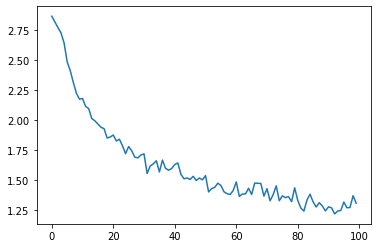

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_loss)

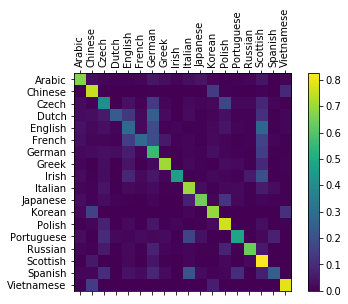

In [53]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)  
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 自己输入姓氏进行判读

In [54]:
def predict(input_line, n_predictions = 3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [60]:
predict('kang')
predict('zhao')
predict('liang')


> kang
(-1.18) German
(-1.52) Chinese
(-1.93) Dutch

> zhao
(-1.75) Chinese
(-1.98) Japanese
(-2.18) Russian

> liang
(-1.40) German
(-1.98) English
(-2.32) Chinese
